In [1]:
import random
import numpy as np
import pandas as pd

from pathlib import Path
from tqdm.notebook import tqdm

In [2]:
data = [
    pd.read_csv(p, sep='|', header=0, index_col=None)
    for p in tqdm(list(Path('training').iterdir()))
]

data_validation = [
    pd.read_csv(p, sep='|', header=0, index_col=None)
    for p in tqdm(list(Path('training_setB').iterdir()))
]
data_ffill = [d.ffill() for d in tqdm(data)]
data_validation_ffill = [d.ffill() for d in tqdm(data_validation)]
data_ewm = [
    pd.concat([d.ffill(), d.drop('SepsisLabel', axis='columns').ewm(alpha=0.25).mean().add_prefix('ewm_')], axis='columns')
    for d in tqdm(data)
]
data_validation_ewm = [
    pd.concat([d.ffill(), d.drop('SepsisLabel', axis='columns').ewm(alpha=0.25).mean().add_prefix('ewm_')], axis='columns')
    for d in tqdm(data_validation)
]

  0%|          | 0/20336 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20336 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20336 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [10]:
# for d in data_ffill:
#     d.SepsisLabel = d.SepsisLabel.max()
# for d in data_validation_ffill:
#     d.SepsisLabel = d.SepsisLabel.max()

In [9]:
HAS_SEPSIS_IDX = pd.Series([i for i, d in enumerate(data) if 1 in d.SepsisLabel.values])
NO_SEPSIS_IDX = pd.Series([i for i, d in enumerate(data) if 0 in d.SepsisLabel.values])
HAS_SEPSIS_ONSET_IDX = pd.Series([i for i, d in enumerate(data) if 1 in d.SepsisLabel.values and 0 in d.SepsisLabel.values])
print(f'''
Has Sepsis: {len(HAS_SEPSIS_IDX)}
Has Sepsis, with onset: {len(HAS_SEPSIS_ONSET_IDX)}
No Sepsis: {len(NO_SEPSIS_IDX)}
Has Sepsis / No Sepsis: {len(HAS_SEPSIS_IDX) / len(NO_SEPSIS_IDX):0.2f}
''')


Has Sepsis: 1790
Has Sepsis, with onset: 1587
No Sepsis: 20133
Has Sepsis / No Sepsis: 0.09



In [11]:
assert all(d.ICULOS.is_monotonic for d in data)
ICU_STAY = pd.Series([max(d.ICULOS.values) for d in data])
pd.DataFrame([
    ICU_STAY[HAS_SEPSIS_IDX].describe(), 
    ICU_STAY[HAS_SEPSIS_ONSET_IDX].describe(),
    ICU_STAY[NO_SEPSIS_IDX].describe(),
], index=['ICU hours with Sepsis', 'ICU hours with Sepsis onset', 'ICU hours without Spesis']).transpose()

,ICU hours with Sepsis,ICU hours with Sepsis onset,ICU hours without Spesis
count,1790.000000,1587.000000,20133.000000
mean,59.544693,65.974165,40.081657
std,57.826063,58.367633,22.455431
min,8.000000,10.000000,8.000000
25%,17.000000,22.000000,26.000000
50%,38.000000,46.000000,40.000000
75%,81.000000,90.000000,48.000000
max,336.000000,336.000000,336.000000


# XGBoost Trial

In [16]:
from sklearn.model_selection import train_test_split

drop_features = ['Unit1', 'Unit2', 'ICULOS', 'ewm_Unit1', 'ewm_Unit2', 'ewm_ICULOS'] #, 'HospAdmTime', 'ICULOS', 'Age']
random.seed(100)
np.random.seed(100)

data_stratify = pd.Series([1 in d.SepsisLabel.values for i, d in enumerate(data_ewm)])
data_train, data_test = train_test_split(data_ewm, stratify=data_stratify, shuffle=True)

dataset_train = pd.concat(data_train, axis='rows').drop(drop_features, axis='columns').sample(frac=1)
dataset_test = pd.concat(data_test, axis='rows').drop(drop_features, axis='columns').sample(frac=1)

X_train = dataset_train.drop('SepsisLabel', axis='columns')
y_train = dataset_train['SepsisLabel']

X_test = dataset_test.drop('SepsisLabel', axis='columns')
y_test = dataset_test['SepsisLabel']

# X = full_dataset.drop('SepsisLabel', axis='columns')
# y = full_dataset['SepsisLabel']
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True)


In [43]:
from xgboost import XGBClassifier
from sklearn.utils import class_weight

sample_weight = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train,
)

params = {
    'objective': 'binary:logistic', 
    'n_estimators': 10,
    'eta': 0.1,
    'lambda': 0.9,
    'alpha': 0.1,
    'subsample': 0.8,
}
model = XGBClassifier(**params, use_label_encoder=False)
model.fit(
    X_train, y_train, 
    eval_set=[(X_train, y_train), (X_test, y_test), (X_valid, y_valid)],
    eval_metric='logloss',
    sample_weight=sample_weight,
)

[0]	validation_0-logloss:0.67217	validation_1-logloss:0.67395	validation_2-logloss:0.66813
[1]	validation_0-logloss:0.65433	validation_1-logloss:0.65713	validation_2-logloss:0.63922
[2]	validation_0-logloss:0.63863	validation_1-logloss:0.64241	validation_2-logloss:0.61559
[3]	validation_0-logloss:0.62496	validation_1-logloss:0.62966	validation_2-logloss:0.59823
[4]	validation_0-logloss:0.61302	validation_1-logloss:0.61918	validation_2-logloss:0.58123
[5]	validation_0-logloss:0.60201	validation_1-logloss:0.60866	validation_2-logloss:0.56089
[6]	validation_0-logloss:0.59218	validation_1-logloss:0.59943	validation_2-logloss:0.54856
[7]	validation_0-logloss:0.58268	validation_1-logloss:0.59066	validation_2-logloss:0.53661
[8]	validation_0-logloss:0.57482	validation_1-logloss:0.58401	validation_2-logloss:0.52164
[9]	validation_0-logloss:0.56621	validation_1-logloss:0.57634	validation_2-logloss:0.50560


XGBClassifier(alpha=0.1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              lambda=0.9, learning_rate=0.100000001, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=10, n_jobs=12,
              num_parallel_tree=1, random_state=0, reg_alpha=0.100000001,
              reg_lambda=0.899999976, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

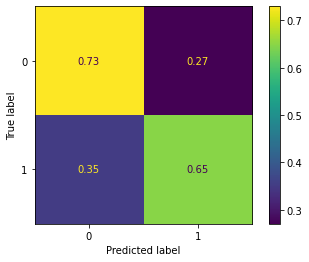

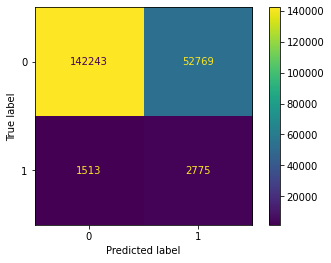

In [44]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test, y_test, normalize='true')
plot_confusion_matrix(model, X_test, y_test)

In [40]:
from sklearn.metrics import f1_score, recall_score, precision_score
y_pred = model.predict(X_test)
(
    f1_score(y_true=y_test, y_pred=y_pred),
    recall_score(y_true=y_test, y_pred=y_pred),
    precision_score(y_true=y_test, y_pred=y_pred),
)


(0.09841206176733333, 0.6294309701492538, 0.053378952989340034)

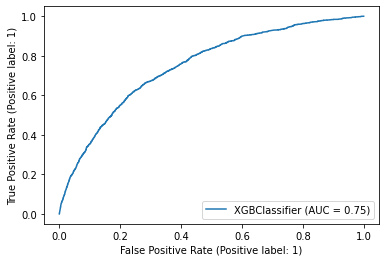

In [45]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(model, X_test, y_test)

# XGBoost Validation

In [35]:
validation_dataset = pd.concat(data_validation_ewm, axis='rows').drop(drop_features, axis='columns')
X_valid = validation_dataset.drop('SepsisLabel', axis='columns')
y_valid = validation_dataset['SepsisLabel']

In [36]:
from sklearn.metrics import f1_score, recall_score, precision_score
y_pred = model.predict(X_valid)
(
    f1_score(y_true=y_valid, y_pred=y_pred),
    recall_score(y_true=y_valid, y_pred=y_pred),
    precision_score(y_true=y_valid, y_pred=y_pred),
)

(0.0680931445854931, 0.2808905380333952, 0.03874253105927812)

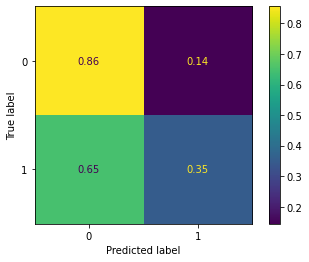

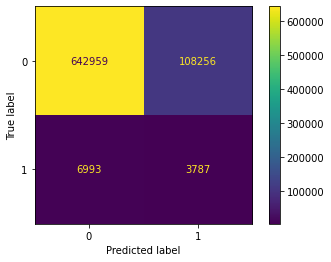

In [27]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_valid, y_valid, normalize='true')
plot_confusion_matrix(model, X_valid, y_valid)

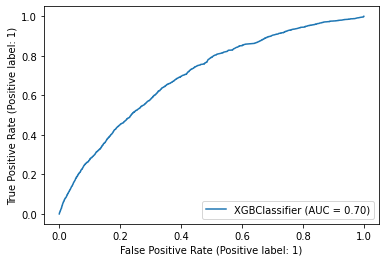

In [47]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(model, X_valid, y_valid)

# Insights (?), and santity checks

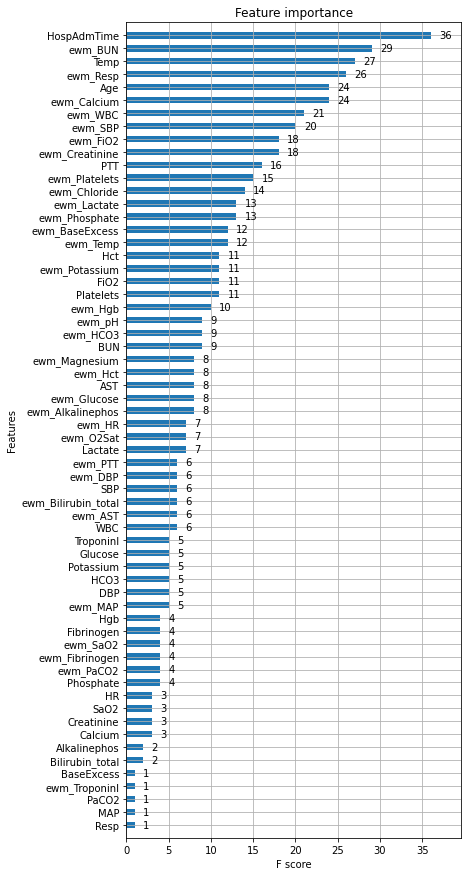

In [30]:
from xgboost.plotting import plot_importance

ax = plot_importance(model, height=0.5)
ax.figure.set_figheight(15)

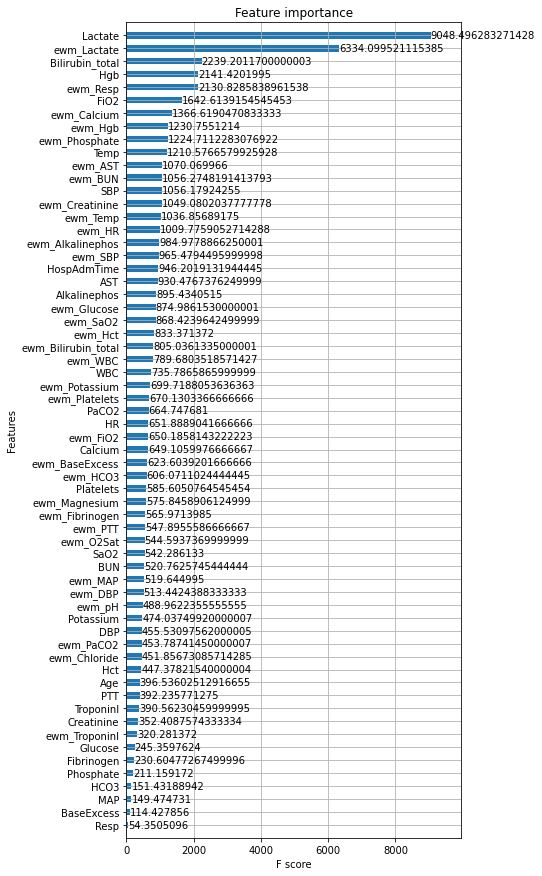

In [29]:
from xgboost.plotting import plot_importance

ax = plot_importance(model, height=0.5, importance_type='gain')
ax.figure.set_figheight(15)

In [55]:
full_dataset.isnull().sum(axis='rows') / len(full_dataset)

HR                  0.077433
O2Sat               0.120320
Temp                0.662243
SBP                 0.152112
MAP                 0.102324
DBP                 0.481258
Resp                0.097768
EtCO2               1.000000
BaseExcess          0.895749
HCO3                0.919494
FiO2                0.858070
pH                  0.885329
PaCO2               0.912318
SaO2                0.950444
AST                 0.985042
BUN                 0.918407
Alkalinephos        0.985407
Calcium             0.950244
Chloride            0.916761
Creatinine          0.933579
Bilirubin_direct    0.998504
Glucose             0.877684
Lactate             0.965651
Magnesium           0.922197
Phosphate           0.949512
Potassium           0.891376
Bilirubin_total     0.987734
TroponinI           0.998779
Hct                 0.882237
Hgb                 0.911643
PTT                 0.951525
WBC                 0.924896
Fibrinogen          0.992369
Platelets           0.934829
Age           